In [7]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torchinfo import summary
from going_moduler import data_setup, engine
import os


print(torch.__version__)
print(torchvision.__version__)

1.13.1
0.14.1


In [6]:
# 1. Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [8]:
# 2. Setup directory path
train_dir = os.path.join("Datasets", "pizza_steak_sushi", "train")
test_dir = os.path.join("Datasets", "pizza_steak_sushi", "test")

## 3. Transforming data

There is one thing we have to think about when loading: How to **transform** it?

And with `torchvision` 0.13+ there's now two ways to do this:-

- 1) Manually created transforms (The Old Way):- You define what transforms you want your data to go through.
- 2) Automatically created transforms (The New Way):- The transforms for your data are defined by the model you'd like to use.

Important point:- When using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transformed** in the same way that the data the model was pre-trained on.

### 3.1 Creating  a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for training).

- We need to transform our own data in the same way that the data the pre-trained model was trained on.

All pre-trained models expect input images normalized in the same way i.e. mini-batches of 3-channel RGB images of 
shape (3 x H x W), where H and W are expected to be atleast 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [11]:
from torchvision import transforms

normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])


manual_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        normalize])

In [13]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
                                    train_dir = train_dir,
                                    test_dir = test_dir,
                                    transform = manual_transforms,
                                    batch_size = 4
                                    )


train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fad3a6c5160>,
 ['pizza', 'steak', 'sushi'])

### Note:- The problem with manual transform for pre-trained model is what if pre-trained model which we want to work has been transformed in a very different way as compared to the manual transformations we are trying to apply. It can degrade model's performance. So its better to apply same transformations as our pre-trained model was trained on. So that is why go for automatic data transform creation for pre-trained model.

### 3.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [14]:
# Get a set of pretrained model weights

weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [15]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

- Same as previous manually created transforms

In [17]:
# Create DataLoaders using automatic transforms

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
                                    train_dir = train_dir,
                                    test_dir = test_dir,
                                    transform = auto_transforms,
                                    batch_size = 4
                                    )

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fad3a813190>,
 ['pizza', 'steak', 'sushi'])

## 4.1 Getting a pretrained model

There are various places to get a pretrained model, such as:-
1. Pytorch domain libraries.
2. Libraries like timm (torch image models).
3. HuggingFace Hub (for plenty of different models).
4. Paperswithcode (for models accross different problem spaces/domains).

Three things to consider before choosing a pre-trained model:-
1. Speed - how fast does it run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images in our case)

In [49]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
#model = torchvision.models.efficientnet_b0(prepretrained = True)

# NEW method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
model = torchvision.models.efficientnet_b0(weights = weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [50]:
# We need to alter this from 1000 out_features to 3 as per our length of output classes.
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 4.2 Getting a summary of our model with `torch.summary()`

In [51]:
from torchinfo import summary

summary(model = model,
        input_size = (1, 3, 224, 224),    # -> input_size = (BS, Color_channel, IMG_SIZE, IMG_SIZE)
        col_names = ["input_size", "output_size", "trainable"],   # names of columns you want. 
        col_width = 15,
        row_settings = ["var_names"])    

Layer (type (var_name))                                      Input Shape     Output Shape    Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 1000]       True
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1280, 7, 7] True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] True
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] True
│    │    └─MBConv (0)                                       [1, 32, 112, 112] [1, 16, 112, 112] True
│    └─Sequential (2)                                        [1, 16, 112, 112] [1, 24, 56, 

## 4.3 Freezing the base model and changing the output layer to suit our needs...

In [52]:
# Freeze all of the base layers in EffNetB0.

for param in model.features.parameters():
    #print(param)
    param.requires_grad = False

In [53]:
# Check the model.classifier
print(f"Current Classifier: {model.classifier}")

Current Classifier: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [56]:
# Update the classifier head of our model to suit our problem
model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = len(class_names))
    ).to(device)

In [58]:
# checking summary again
summary(model = model,
        input_size = (1, 3, 224, 224),    # -> input_size = (BS, Color_channel, IMG_SIZE, IMG_SIZE)
        col_names = ["input_size", "output_size", "trainable"],   # names of columns you want. 
        col_width = 15,
        row_settings = ["var_names"])    

Layer (type (var_name))                                      Input Shape     Output Shape    Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 3]          Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1280, 7, 7] False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] False
│    │    └─MBConv (0)                                       [1, 32, 112, 112] [1, 16, 112, 112] False
│    └─Sequential (2)                                        [1, 16, 112, 112] [1,

## 5. Train Model

In [59]:
# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [64]:
# Import train function
from going_moduler import engine

# Set the manual seed
torch.manual_seed(42)

# Setup training and save results
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       loss_fn = loss_fn,
                       optimizer = optimizer,
                       epochs = 10,
                       device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.2171 | Train acc: 0.9211 | Test Loss: 0.6492 | Test Acc: 0.7895
Epoch: 1 | Train Loss: 0.3920 | Train acc: 0.8465 | Test Loss: 0.5397 | Test Acc: 0.7895
Epoch: 2 | Train Loss: 0.3453 | Train acc: 0.8684 | Test Loss: 0.4919 | Test Acc: 0.8289
Epoch: 3 | Train Loss: 0.2150 | Train acc: 0.9211 | Test Loss: 0.5793 | Test Acc: 0.7895
Epoch: 4 | Train Loss: 0.2372 | Train acc: 0.9167 | Test Loss: 0.4860 | Test Acc: 0.8158


# 6. Plot Loss Curves

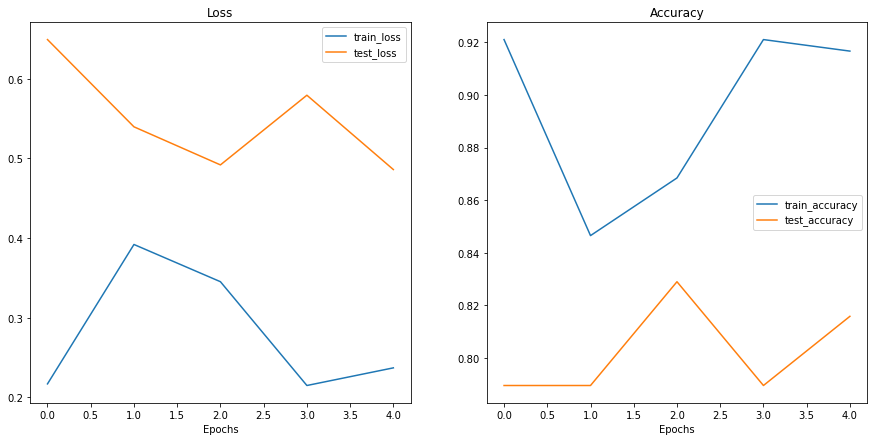

In [66]:
from helper_functions import plot_loss_curves

plot_loss_curves(results = results)

# 7. Make predictions on images from the test set


As we are going to test our model on custom test data, we need to make sure our custom test data follows some following things:-

1. Same shape - images need to be same shape as model was trained on.
2. Same datatype - custom data should be in the same datatype.
3. Same device - custom data/test data should be on same device as the model is.

To do all of this tasks automatically, let's create a function called `pred_and_plot_image()`

In [81]:
from PIL import Image

# 1. Take in a trained model...
def pred_and_plot_image(model, 
                        image_path: str,
                        class_names: list[str],
                        image_size = tuple[int, int],
                        transform = None,
                        device = device):
    
    # 2. Open the image with PIL
    img = Image.open(image_path)
    
    # 3. Create a transform if one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
             transforms.Resize(image_size),
             transforms.ToTensor(),
             transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])
        ])
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on eval mode and inference mode 
    model.eval()
    with torch.inference_mode():
        # 6. transform the image and add an extra batch dimension.
        transformed_image = image_transform(img).unsqueeze(dim = 0)
        
        # 7. Make a prediction on transformed image also ensure its on right device. 
        target_image_pred = model(transformed_image.to(device))
        
    # Convert the model's output logits to pred_probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
    
    # Convert the model's pred probs to pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)
    
    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)
    plt.show()

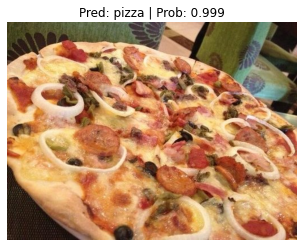

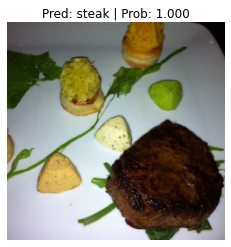

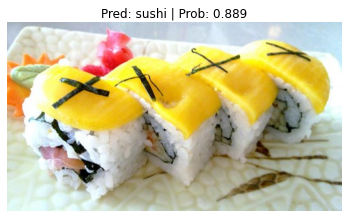

In [82]:
# Predicting on List of images:- Get a random list of image paths from the test set

import random
from path import Path
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population = test_image_path_list, k = num_images_to_plot)


# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model = model,
                        image_path = image_path,
                        class_names = class_names,
                        image_size = (224, 224))

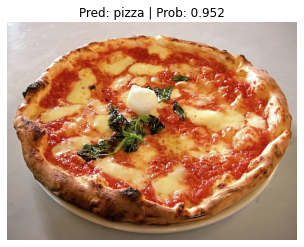

In [84]:
# Predicting on a Custom Image...
custom_image_path = os.path.join("Datasets", "Eq_it-na_pizza-margherita_sep2005_sml.jpg")

pred_and_plot_image(model = model,
                    image_path = custom_image_path,
                    class_names = class_names,
                    image_size = (224, 224))